In [13]:
import librosa
import librosa.display
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
#import skimage
#from skimage import io


# def scale_minmax(X, min=0.0, max=1.0):
#     X_std = (X - X.min()) / (X.max() - X.min())
#     X_scaled = X_std * (max - min) + min
#     return X_scaled
def save_png(filename,soundpath,savepath):
    x = 0
    #オーディオファイルの読み込み
    music, fs = librosa.audio.load(soundpath + filename)
    #フーリエ変換
    D = librosa.stft(music)
    #メルスペクトログラム変換
    mfccs = librosa.feature.melspectrogram(D, sr=fs, n_mels=128)
    #データ内容をGAIN(db)に変換
    mfccspw = librosa.power_to_db(mfccs, ref=np.max)
    #無音部分の除去
    mfccspw = (mfccspw[:, np.any(mfccspw > -40, axis=0)])

    for i in np.arange(0, len(mfccspw[1])-10, 10):

        split = mfccspw[:,i:i+10]
        
        # save as PNG
        img = split.astype(np.uint8)
        matplotlib.image.imsave(savepath + filename +"("+str(x)+")"+ '.png', img)

#        cv2.imwrite(savepath + filename +"("+str(x)+")"+ '.png', img)
        x +=1
soundpath = './guiter_wav/6/'
savepath = './guiter_wav_image10/6/'
cnt = 0
for filename in os.listdir(soundpath):
    cnt += 1
    if((cnt % 10) == 0):
        print(cnt,'件を処理しました')
    save_png(filename,soundpath,savepath)

In [3]:
import os
import sys
import glob
import numpy as np
from skimage import io
#from sklearn import datasets
from sklearn import utils
import cv2
from PIL import Image
 
IMAGE_SIZE_X = 10
IMAGE_SIZE_Y = 10
COLOR_BYTE = 3
#COLOR_BYTE = 1
CATEGORY_NUM = 6
threshhold = 80
 
## ラベル名(0～)を付けたディレクトリに分類されたイメージファイルを読み込む
## 入力パスはラベル名の上位のディレクトリ
def load_split_bin(path):
    # ファイル一覧を取得
    files1 = glob.glob(os.path.join(path, '*/*.png'))
    files = []
    for i in files1:
        #大きいファイルを開いて
        gazo1 = Image.open(i)
        #resizeして
        gazo2 = gazo1.resize((IMAGE_SIZE_X,IMAGE_SIZE_Y))
  
        #filesに追加
        files.append(gazo2)

    # イメージとラベル領域を確保
    #images = np.ndarray((len(files), IMAGE_SIZE, IMAGE_SIZE,
    #                      COLOR_BYTE), dtype = np.uint8)
    images = np.ndarray((len(files), IMAGE_SIZE_X, IMAGE_SIZE_Y)
                       , dtype = np.uint8)

    labels = np.ndarray(len(files), dtype=np.int)

    # イメージとラベルを読み込み
    for idx, file in enumerate(files):
        # イメージ読み込み
        img = io.imread(file)
        # ディレクトリ名よりラベルを取得
        label = os.path.split(os.path.dirname(file))[-1]
        labels[idx] = int(label)

        # scikit-learn の他のデータセットの形式に合わせる
        flat_data = images.reshape((-1, IMAGE_SIZE_X * IMAGE_SIZE_Y * COLOR_BYTE))
        images = flat_data.view()
    return utils.Bunch(data=images,
                 target=labels.astype(np.int),
                 target_names=np.arange(CATEGORY_NUM),
                 images=images,
                 DESCR=None)

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import sys
from PIL import Image
from keras.datasets import mnist
# keras用のパラメータ
batch_size =  64
#epochs = 500
epochs = 40

# mel画像のサイズ 縦(row)と横(col)
img_rows, img_cols = 100, 100

# 学習結果を保存するファイルの決定
savefile = "mel.h5"


paths_for_train = ["./guiter_wav_image/"]

# 手書き数字のデータをロードし、変数digitsに格納
# digits = datasets.load_digits()
# (X, y), (x_test, y_test) = mnist.load_data()
# X = np.concatenate(data)
# y = np.concatenate(label)
# np.random.seed(1)
# np.random.shuffle(X)
# np.random.seed(1)
# np.random.shuffle(y)
data = []
label = []
for i in range(len(paths_for_train)):
    path = paths_for_train[i]
    d = load_split_bin(path)
    data.append(d.data)
    label.append(d.target)
X = np.concatenate(data)
y = np.concatenate(label)

# 特徴量のセットを変数Xに、ターゲットを変数yに格納
#X = digits.data
#y = digits.target

# クラス数の取り出し
n_classes = len(np.unique(y))

# データXをCNN用の形式に変換
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
# ターゲットyをkeras用の形式に変換
y_keras = keras.utils.to_categorical(y, n_classes)

# 畳み込みニューラルネットワークを定義
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=n_classes, activation='softmax'))

# モデルのコンパイル
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

# モデルの学習
history = model.fit(X, y_keras, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2)

# 結果の表示
result = model.predict_classes(X, verbose=0)

# データ数をtotalに格納
total = len(X)
# ターゲット（正解）と予測が一致した数をsuccessに格納
success = sum(result==y)

# 正解率をパーセント表示
print('正解率')
print(100.0*success/total)

# 学習結果を保存
model.save(savefile)

# 損失関数のグラフの軸ラベルを設定
plt.xlabel('time step')
plt.ylabel('loss')

# グラフ縦軸の範囲を0以上と定める
plt.ylim(0, max(np.r_[history.history['val_loss'], history.history['loss']]))

# 損失関数の時間変化を描画
val_loss, = plt.plot(history.history['val_loss'], c='#56B4E9')
loss, = plt.plot(history.history['loss'], c='#E69F00')

# グラフの凡例（はんれい）を追加
plt.legend([loss, val_loss], ['loss', 'val_loss'])

# 描画したグラフを表示
plt.show()

OSError: Cannot understand given URI: <PIL.Image.Image image mode=RGBA size=100x100 at 0x7F18A8....

In [14]:
def load_split_bin(path):
    # ファイル一覧を取得
    files = glob.glob(os.path.join(path, '*/*.png'))

    # イメージとラベル領域を確保
    images = np.ndarray((len(files), IMAGE_SIZE_X, IMAGE_SIZE_Y,
                          COLOR_BYTE), dtype = np.uint8)
    #images = np.ndarray((len(files), IMAGE_SIZE_X, IMAGE_SIZE_Y)
    #                   , dtype = np.uint8)

    labels = np.ndarray(len(files), dtype=np.int)

    # イメージとラベルを読み込み
    for idx, file in enumerate(files):
        # イメージ読み込み
        img = io.imread(file)
        # ディレクトリ名よりラベルを取得
        label = os.path.split(os.path.dirname(file))[-1]
        labels[idx] = int(label)

        # scikit-learn の他のデータセットの形式に合わせる
    flat_data = images.reshape((-1, IMAGE_SIZE_X * IMAGE_SIZE_Y * COLOR_BYTE))
    images = flat_data.view()
    return utils.Bunch(data=images,
                 target=labels.astype(np.int),
                 target_names=np.arange(CATEGORY_NUM),
                 images=images,
                 DESCR=None)



Train on 3206 samples, validate on 357 samples
Epoch 1/40
 - 5s - loss: 22.9242 - accuracy: 0.1628 - val_loss: 2.0043 - val_accuracy: 0.0000e+00
Epoch 2/40
 - 4s - loss: 1.9496 - accuracy: 0.1740 - val_loss: 2.0564 - val_accuracy: 0.0000e+00
Epoch 3/40
 - 4s - loss: 1.9657 - accuracy: 0.1747 - val_loss: 2.1180 - val_accuracy: 0.0000e+00
Epoch 4/40
 - 4s - loss: 1.9260 - accuracy: 0.1734 - val_loss: 2.1803 - val_accuracy: 0.0000e+00
Epoch 5/40
 - 4s - loss: 1.9735 - accuracy: 0.1784 - val_loss: 2.2403 - val_accuracy: 0.0000e+00
Epoch 6/40
 - 4s - loss: 1.9469 - accuracy: 0.1756 - val_loss: 2.2970 - val_accuracy: 0.0000e+00
Epoch 7/40
 - 4s - loss: 1.9775 - accuracy: 0.1737 - val_loss: 2.3543 - val_accuracy: 0.0000e+00
Epoch 8/40
 - 4s - loss: 1.9049 - accuracy: 0.1750 - val_loss: 2.4105 - val_accuracy: 0.0000e+00
Epoch 9/40
 - 4s - loss: 1.9268 - accuracy: 0.1759 - val_loss: 2.4637 - val_accuracy: 0.0000e+00
Epoch 10/40
 - 4s - loss: 1.9199 - accuracy: 0.1759 - val_loss: 2.5153 - val_

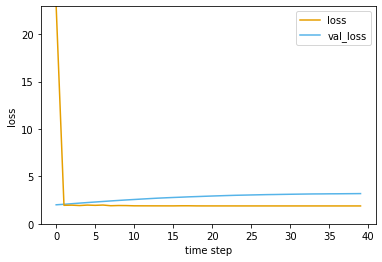

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import sys
from PIL import Image
from keras.datasets import mnist
from load_split_bin import load_split_bin

# keras用のパラメータ
batch_size =  64
#epochs = 500
epochs = 40

# mel画像のサイズ 縦(row)と横(col)
img_rows, img_cols = 128, 10

# 学習結果を保存するファイルの決定
savefile = "mel.h5"


paths_for_train = ["./guiter_wav_image10/"]

# 手書き数字のデータをロードし、変数digitsに格納
# digits = datasets.load_digits()
# (X, y), (x_test, y_test) = mnist.load_data()
# X = np.concatenate(data)
# y = np.concatenate(label)
# np.random.seed(1)
# np.random.shuffle(X)
# np.random.seed(1)
# np.random.shuffle(y)
data = []
label = []
for i in range(len(paths_for_train)):
    path = paths_for_train[i]
    d = load_split_bin(path)
    data.append(d.data)
    label.append(d.target)
X = np.concatenate(data)
y = np.concatenate(label)

# 特徴量のセットを変数Xに、ターゲットを変数yに格納
#X = digits.data
#y = digits.target

# クラス数の取り出し
n_classes = len(np.unique(y))

# データXをCNN用の形式に変換
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
# ターゲットyをkeras用の形式に変換
y_keras = keras.utils.to_categorical(y, n_classes)

# 畳み込みニューラルネットワークを定義
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=n_classes, activation='softmax'))

# モデルのコンパイル
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

# モデルの学習
history = model.fit(X, y_keras, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2)

# 結果の表示
result = model.predict_classes(X, verbose=0)

# データ数をtotalに格納
total = len(X)
# ターゲット（正解）と予測が一致した数をsuccessに格納
success = sum(result==y)

# 正解率をパーセント表示
print('正解率')
print(100.0*success/total)

# 学習結果を保存
model.save(savefile)

# 損失関数のグラフの軸ラベルを設定
plt.xlabel('time step')
plt.ylabel('loss')

# グラフ縦軸の範囲を0以上と定める
plt.ylim(0, max(np.r_[history.history['val_loss'], history.history['loss']]))

# 損失関数の時間変化を描画
val_loss, = plt.plot(history.history['val_loss'], c='#56B4E9')
loss, = plt.plot(history.history['loss'], c='#E69F00')

# グラフの凡例（はんれい）を追加
plt.legend([loss, val_loss], ['loss', 'val_loss'])

# 描画したグラフを表示
plt.show()